In [1]:
import matplotlib.pyplot as plt
import sys
import math
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
from pyaxions import jaxions as pa
from pyaxions import spectrum as sp

This notebook describes the usage of functions in spectrum.py (version f6d6e12 Sat Aug 6 2022).

# Preliminaries

First we extract the data of axion spectra and save them as pickle files, since accessing m files takes somewhat long time (particularly for simulations with huge grid sizes). Here we use the results of 8 sample simulations with the size of 512^3 and PRS strings (`msa=1.0`).

In [2]:
# path to m files
mpath = './simus'
mflist = []
for id in range(8):
    mf = pa.findmfiles(mpath+'/simu%02d/'%id)
    mflist.append(mf)

## spectrum.espevol <font color='red'>[updated 2022.08.05]</font>

`espevol` extracts the axion (or saxion) energy spectrum and its time evolution.
```python
class espevol:
    def __init__(self, mfiles, esplabel='espK_0'):
```
esplabel option specifies the data label. For example:  
`'espK_0'` kinetic energy spectrum (with LUT correction)  
`'espCK_0'` kinetic energy spectrum (without LUT correction)  
`'espCK_Red_1.50'` kinetic energy spectrum (without LUT correction) with top-hat mask from Gaussian cut and $r_{\rm mask}=1.50$  
`'espKS_0'` saxion kinetic energy spectrum

Outputs (class members):  
- `sizeN` grid size  
- `sizeL` comoving box size  
- `msa` $m_r a$ (at the initial time)  
- `LL` lambda0  
- `nm` list of the number of modes  
- `avek` list of comoving wavenumber  
- `k_below` mask to identify modes less than N/2
- `ttab` table for conformal time
- `logtab` table for $\log(m_r/H)$
- `esp` energy spectrum, defined as (for axions)
\begin{align}
{\tt esp}(k) = \frac{1}{2}\frac{R^2}{L^3}|\theta_{\tau}(k)|^2 = \frac{1}{2L^3}\frac{R^4}{R_1^2H_1^2}|\dot{\theta}(k)|^2.
\end{align}
For saxions, it corresponds to the one obtained through the replacement $\theta_{\tau}\to \rho_{\tau}/f_a$ 
in the above equation, where $\rho$ is the radial direction of the PQ field.
Here we use a rescaled conformal time defined as
\begin{align}
Rd\tau = R_1H_1dt,
\end{align}
which is related to the conventional conformal time ($Rd\eta = dt$) as $\tau = R_1H_1\eta$.  
${\tt esp}$ is an array with the shape esp[t][k], where t is the time index and k is the index for momenta (ttab[t] and logtab[t] show the corresponding values of time and log).

In [3]:
espt = sp.espevol(mflist[0])

<Figure size 432x288 with 0 Axes>

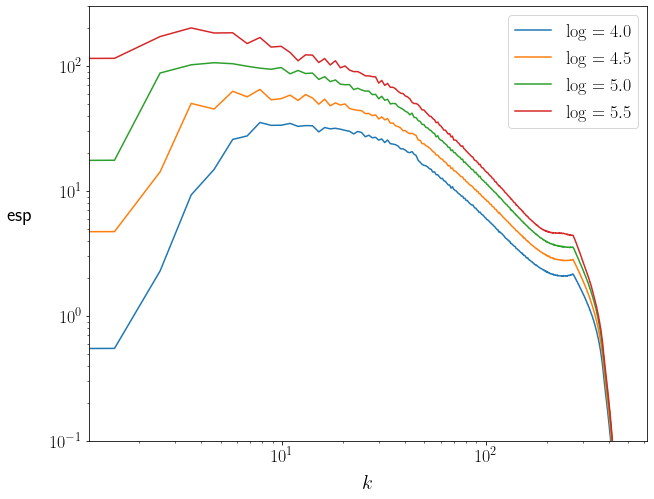

In [4]:
plt.clf()
plt.figure(figsize=(10,8))
logil = [4,4.5,5,5.5]
for log in logil:
    it = np.abs(espt.logtab - log).argmin()
    plt.plot(espt.avek,espt.esp[it][:],label=r'$\log = %.1f$'%espt.logtab[it])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,3e+2)
plt.xlabel(r'$k$',fontsize=20,labelpad=10)
plt.ylabel(r'esp',fontsize=20,rotation=0,labelpad=30)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right',fontsize=18)

## spectrum.saveesp <font color='red'>[updated 2022.08.05]</font>
```python
def saveesp(espe, name='./esp', esplabel='espK_0', esponly=False):
```
This function saves `esp`, `nm`, `avek`, `k_below`, `ttab`, and `logtab` data as pickle files. These files are named `name_something`, where something = esplabel, nm, k, k_below, t, log. When `esponly=True`, it does not produce pickle files for `nm`, `avek`, `k_below`, `ttab`, and `logtab`, and save `esp` data only. One may use this option in order to avoid duplication if there are more than one spectrum types.

In [5]:
# This produces the following files (with id = 00, 01, ..., 07) in the directory ./espdata :
#
# id_espK_0.pickle
# id_espKS_0.pickle
# id_k_below.pickle
# id_k.pickle
# id_log.pickle
# id_nm.pickle
# id_t.pickle
#
for id in range(8):
    esp = sp.espevol(mflist[id])
    sp.saveesp(esp,'./espdata/%02d'%id)
    espS = sp.espevol(mflist[id],'espKS_0')             # saxion spectrum
    sp.saveesp(espS,'./espdata/%02d'%id,'espKS_0',True) # saxion spectrum

## spectrum.readS <font color='red'>[added 2022.05.09]</font>
```python
class readS:
    def __init__(self,dataname='./Sdata/S',esplabel='espK_0'):
```
This reads the data of spectra spicified by `esplabel`.

Outputs (class members):  
- `dataname` dataneme specified in the argument, which should be the same as `name` in the spectrum.saveesp function described above.
- `nm` list of the number of modes  
- `k` list of comoving wavenumber  
- `k_below` mask to identify modes less than N/2
- `t` table for conformal time
- `log` table for $\log(m_r/H)$
- `esp` (kinetic) energy spectrum
- `Narr` array for dimensionless number spectrum defined as
\begin{align}
\mathcal{N} \equiv \frac{1}{Hf_a^2}\frac{\partial\rho}{\partial(k/R)} = \frac{R_1H_1}{R^3H}\frac{k^2}{\pi^2}\frac{{\tt esp}(k)}{{\tt nm}(k)}.
\end{align}
This is an array with the shape N[t][k], where k is the index for momenta, and t is the time index (t[t] and log[t] show the corresponding values of time and log).
- `Earr` array for dimensionless energy spectrum defined as
\begin{align}
\mathcal{E} \equiv \frac{k}{(f_aH)^2}\frac{\partial\rho}{\partial k} = \frac{R_1^2H_1^2}{R^4H^2}\frac{k^3}{\pi^2}\frac{{\tt esp}(k)}{{\tt nm}(k)}.
\end{align}
This is an array with the shape E[t][k], where k is the index for momenta, and t is the time index (t[t] and log[t] show the corresponding values of time and log).

Methods:
- `N(log)` returns the dimensionless number spectrum $\mathcal{N}$ at a time step closest to 
the value of `log` (float) specified in the argument.
This is an array with the shape N[k], where k is the index for momenta.
- `E(log)` returns the dimensionless energy spectrum $\mathcal{E}$ at a time step closest to 
the value of `log` (float) specified in the argument.
This is an array with the shape E[k], where k is the index for momenta.
- `Nevol(ik)` returns the time evolution of $\mathcal{N}$ for a given mode index ik (int). This is an array with the shape N[t], where t is the time index (t[t] and log[t] show the corresponding values of time and log).
- `Eevol(ik)` returns the time evolution of $\mathcal{E}$ for a given mode index ik (int). This is an array with the shape E[t], where t is the time index (t[t] and log[t] show the corresponding values of time and log).

In [6]:
# read the data of spectra and produce a list for 8 realizations
SAlist = []  # axion spectrum
SSlist = []  # saxion spectrum
for id in range(8):
    ra = sp.readS('./espdata/%02d'%id)
    rs = sp.readS('./espdata/%02d'%id,'espKS_0')
    SAlist.append(ra)
    SSlist.append(rs)

<Figure size 432x288 with 0 Axes>

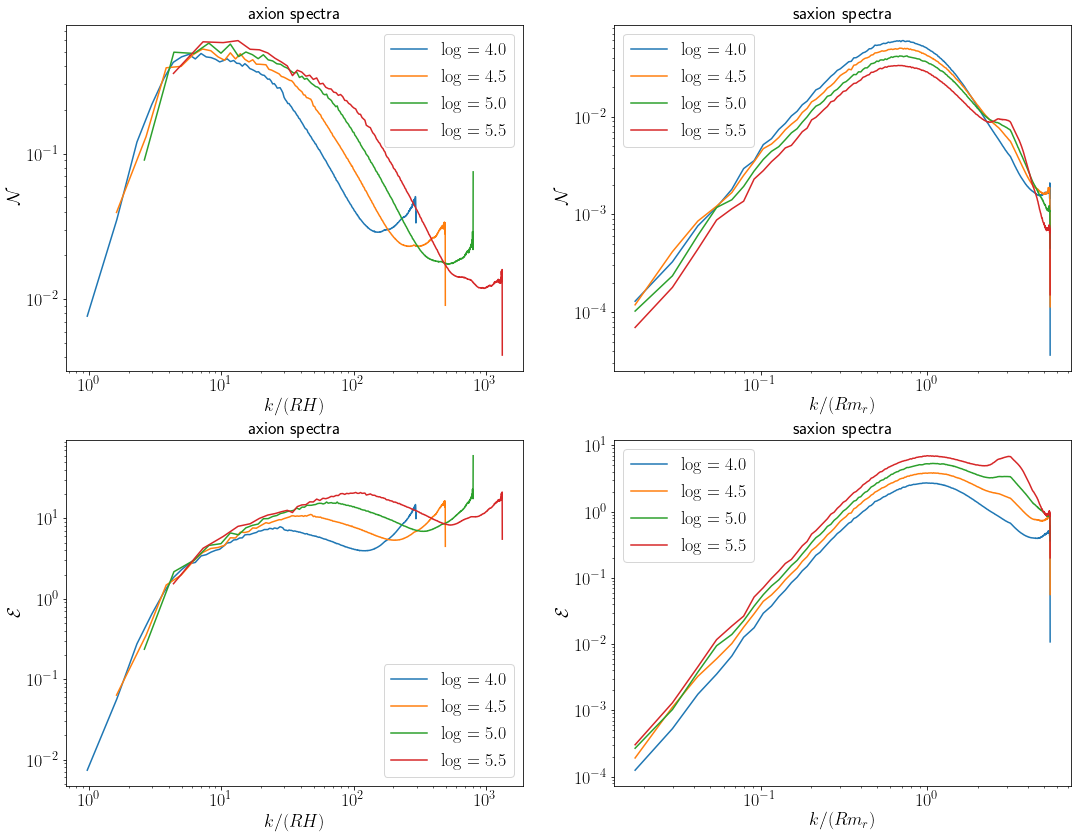

In [7]:
plt.clf()
fig, ax = plt.subplots(2,2,figsize=(18,14))
id = 0
logil = [4,4.5,5,5.5]
for log in logil:
    it = np.abs(SAlist[id].log - log).argmin()
    na = SAlist[id].N(log)[1:]
    ns = SSlist[id].N(log)[1:]
    ea = SAlist[id].E(log)[1:]
    es = SSlist[id].E(log)[1:]
    ka = SAlist[id].k[1:]*SAlist[id].t[it]
    ks = SSlist[id].k[1:]*SSlist[id].t[it]/np.exp(SSlist[id].log[it])
    ax[0,0].plot(ka,na,label=r'$\log = %.1f$'%SAlist[id].log[it])
    ax[0,1].plot(ks,ns,label=r'$\log = %.1f$'%SSlist[id].log[it])
    ax[1,0].plot(ka,ea,label=r'$\log = %.1f$'%SAlist[id].log[it])
    ax[1,1].plot(ks,es,label=r'$\log = %.1f$'%SSlist[id].log[it])
for ii in range(4):
    ro = ii//2
    co = ii%2
    ax[ro,co].set_xscale('log')
    ax[ro,co].set_yscale('log')
    ax[ro,co].tick_params(labelsize=18)
    ax[ro,co].legend(fontsize=18)
    if ro==0:
        ax[ro,co].set_ylabel('$\mathcal{N}$',fontsize=18)
    else:
        ax[ro,co].set_ylabel('$\mathcal{E}$',fontsize=18)
    if co==0:
        ax[ro,co].set_xlabel('$k/(RH)$',fontsize=18)
        ax[ro,co].set_title('axion spectra',fontsize=18)
    else:
        ax[ro,co].set_xlabel('$k/(Rm_r)$',fontsize=18)
        ax[ro,co].set_title('saxion spectra',fontsize=18)

A remarkable feature is that it shows an universal behavior for the evolution of the modes outside the horizon.
This will be used to calculate the instantaneous spectrum by performing the analytical fit.

<Figure size 432x288 with 0 Axes>

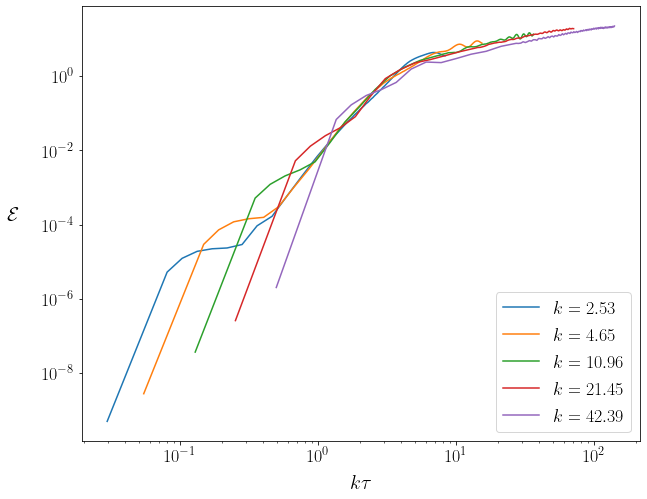

In [8]:
id = 0

plt.clf()
plt.figure(figsize=(10,8))

for ik in [2,4,10,20,40]:
    plt.plot(SAlist[id].k[ik]*SAlist[id].t,SAlist[id].Eevol(ik),label=r'$k=%.2f$'%SAlist[id].k[ik])
plt.xlabel(r'$k\tau$',fontsize=20,labelpad=10)
plt.ylabel(r'$\mathcal{E}$',fontsize=20,rotation=0,labelpad=30)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(loc='lower right',fontsize=18)

## spectrum.saxionZ <font color='red'>[added 2022.05.09]</font>
```python
def saxionZ(k, t, LL, lz2e=0):
```
For given values of $k$ and $\tau$, this function returns the redshift exponent for the saxion spectrum, which is defined as
\begin{align}
z[k] = 3 - \frac{d\log\omega(k)}{d\log R} 
= 3 + \frac{1}{1+\left(\frac{k}{Rm_r}\right)^2}\left[\left(\frac{k}{Rm_r}\right)^2-\frac{d\log m_r}{d\log R}\right],
\end{align}
where $\omega(k) = \sqrt{m_r^2+k^2/R^2}$, so that the saxion energy density scales as $\frac{d\rho}{d\log k} \propto R^{-z[k]}$ if the comoving saxion number remains constant.
It assumes general power law behavior of the (unphysical) saxion mass,
\begin{align}
m_r^2 \propto R^{-{\tt lz2e}}.
\end{align}
Note that, for PRS (${\tt lz2e}=1$) and physical (${\tt lz2e}=0$) strings, it can be simplified as
\begin{align}
z[k] = 
\begin{cases}
4 & (\text{PRS}),\\
3 + \frac{\left(\frac{k}{Rm_r}\right)^2}{1+\left(\frac{k}{Rm_r}\right)^2} & (\text{physical}).
\end{cases}
\end{align}

<Figure size 432x288 with 0 Axes>

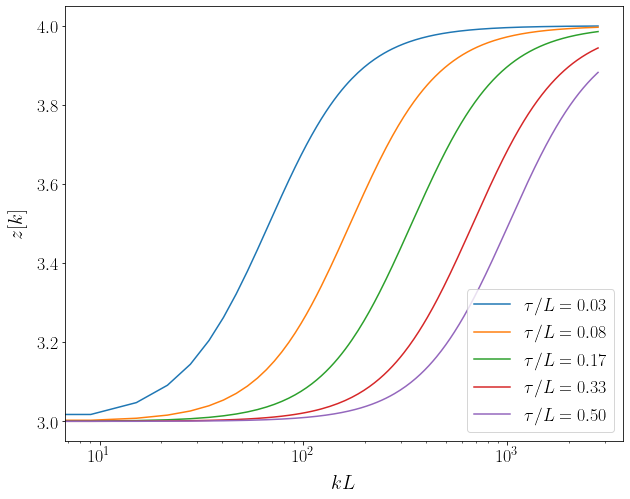

In [9]:
# behavior of z[k] for physical strings assuming LL=1600 (lambda value) and L=6 (comoving box size)
plt.clf()
plt.figure(figsize=(10,8))
L=6.
for tau in [0.2,0.5,1.,2.,3.]:
    kk = SAlist[0].k
    z = sp.saxionZ(kk,tau,1600.)
    plt.plot(kk*L,z,label=r'$\tau/L = %.2f$'%(tau/L))
plt.xscale('log')
plt.xlabel(r'$kL$',fontsize=20,labelpad=10)
plt.ylabel(r'$z[k]$',fontsize=20,labelpad=10)
plt.tick_params(labelsize=18)
plt.legend(loc='lower right',fontsize=18)

<font color='red'>
If one prepares a data set that has the same structure as spectrum.readS, in principle one can use the following functions without any modification.
</font>

# Instantaneous spectrum

The instantaneous spectrum is defined as
\begin{align}
\mathcal{F}_a&\equiv \frac{1}{(f_aH)^2}\frac{1}{R^3}\frac{\partial}{\partial t}\left(R^4\frac{\partial\rho_a}{\partial k}\right) \quad (\text{for axions}),\\
\mathcal{F}_r&\equiv \frac{1}{(f_aH)^2}\frac{1}{R^{z[k]-1}}\frac{\partial}{\partial t}\left(R^{z[k]}\frac{\partial\rho_r}{\partial k}\right) \quad (\text{for saxions}).
\end{align}
In terms of $\mathcal{E}$ and $x = k\eta$, it can be written as
\begin{align}
\mathcal{F}_a = \frac{\partial\mathcal{E}_a}{\partial x},\quad \mathcal{F}_r = \frac{1}{R^{z[k]-4}}\frac{\partial(R^{z[k]-4}\mathcal{E}_r)}{\partial x},
\end{align}
or
\begin{align}
\mathcal{F} = \frac{\exp[f(\ell)]}{x}\frac{\partial f(\ell)}{\partial \ell}\cdot
\begin{cases} 
1 & (\text{axions})\\
\frac{1}{\tau^{z[k]-4}} & (\text{saxions})
\end{cases}
\end{align}
where
\begin{align}
f(\ell) = 
\begin{cases}
\log \mathcal{E} & (\text{axions})\\
\log (\tau^{z[k]-4}\mathcal{E}) & (\text{saxions})
\end{cases}
\end{align}
and $\ell = \log x$.

## spectrum.fitS <font color='red'>[updated 2022.05.09]</font>
<font color='red'>(This function was called fitP in the old version. Most of its functionalities remain the same except that it can also perform the fit for saxion spectra.)</font>

`fitS` fits some analytical functions to the data of $\mathcal{E}$.  
```python
class fitS:
    def __init__(self, data, log, t, k, **kwargs):
```
Arguments:
- `data` data array of $\mathcal{E}$ (`spectrum.readS.Earr`)
- `log` table for $\log(m_r/H)$
- `t` table for conformal time
- `k` list of comoving wavenumber

If necessary, the following options can be added:
- `p` order of the polynomial function (only supports p = 2,3,4,5; default p = 3; see below)
- `logstart` value of $\log(m_r/H)$ above which we perform the analytical fit (default logstart = 4)
- `verbose` option for progress messages (default verbose = 1)  
 1 : prints progress messages (overwriting the previous line)  
 2 : prints progress messages (not overwriting the previous line)  
 others : does not print progress messages
- `xh` default is xh = -1. If xh is some positive value, it switches to a simplified fit function when x[0] becomes larger than xh. If xh = -1 (or some negative value), it does not use this simplification.
- `saxionmass` default is False. If True, it takes account of the non-trivial redshift for saxion spectra.
- `LL` value of lambda parameter for physical strings (relevant only when `saxionmass=True`; defalult LL = 1600.0).
- `lz2e` value of the exponent of the power law evolution of the lambda parameter for physical strings (relevant only when `saxionmass=True`; default lz2e = 0).

Outputs (class members):
- `param` best fit parameters. This is an array with the shape a[ik][i], where ik is the index of a comoving momentum for which the fit is performed, and i is the index of the model parameters.
- `paramv` variance of fit parameters. This is an array with the shape a[ik][i], where ik is the index of a comoving momentum for which the fit is performed, and i is the index of the model parameters.
- `listfit` a boolean list with the shape listfit[ik], where ik is the index of a comoving momentum. It becomes False when the fit fails, and True when the fit successfully works at the corresponding momentum.
- `ikhistart` index ik at which an approximation for the fit function starts (see below)

`fitS` uses `scipy.optimize.curve_fit` to fit the following functions to data of $\log \mathcal{E}$ (if saxionmass=False):

\begin{align}
f(\ell) = a_0 + a_1\ell - \log(1+(a_2 e^{\ell})^{a_3 + a_4\ell+\cdots +a_{3+p}\ell^p}),
\end{align}

where $\ell = \log x$. Note that these functions should be fitted to $\log \mathcal{E}$ rather than $\mathcal{E}$, and $\mathcal{E}(x)$ should describe the time evolution of one mode (with $k$ fixed). In the code, they are defined as (togher with their derivatives with respect to $\ell$)
```python
def ftrend(lx, order, *args):
    ...
def dftrend(lx, order, *args):
    ...
```
where `lx` is $\ell$, `order` is the value of $p$, and the number of `*args` should be $p+3$. For example, `ftrend(lx, 3, a0, a1, a2, a3, a4, a5)` gives a function with $p=3$ and `dftrend(lx, 3, a0, a1, a2, a3, a4, a5)` gives its derivatives with respect to $\ell$.

If `saxionmass = True`, it performes the fit for $\log (\tau^{z[k]-4}\mathcal{E})$ rather than $\log \mathcal{E}$ by calculating $z[k]$ appropriately by using `spectrum.saxionZ`.

The class `fitS` iteratively performes the analytical fit for every mode $k$ and stores the best fit values of $\{a_i\}$ as a class member `param`. It is an array with the shape a[ik][i], where ik is the index of a comoving momentum for which the fit is performed, and i is the index of the model parameters $\{a_i\}$.  

For sufficiently large values of $x$, the above function can be approximated by

\begin{align}
f_a(\ell) = a_0' + a_1'\ell + \cdots + a_p'\ell^p.
\end{align}

One can accerelate the fit procedure by using this approximation. If some positive value of `xh` is provided, `fitS` switches to use the approximated function for modes satisfying x[0] > xh. Note that this may create a discontinuity at around $k \simeq $ xh$/\tau_{\rm start}$ (where $\tau_{\rm start}$ corresponds to the conformal time specified by `logstart`), and hence one has to choose a sufficiently high value of xh (or simply set xh < 0 (default)) so that it does not affect the measurement of relevant quantities such as $\mathcal{F}$ and $q$. The index ik at which the approximation starts is stored as a class member `ikhistart`.  

In the code, the approximated functions and their derivatives with respect to $\ell$ are defined as
```python
def ftrenda(lx, order, *args):
    ...
def dftrenda(lx, order, *args):
    ...
```
where the number of `*args` should be $p+1$, which is not the same as the full function ($p+3$).  

In case the fit procedure does not work and fails to find the parameters $\{a_i\}$
for some reason (unusual behavior of the data, etc.), such information is stored in a class member `listfit`.
It is a boolean array with the shape a[ik], where ik is the index of a comoving momentum, and becomes False
when the fit fails at the corresponding momentum. Such a bin will not be used for the calculation of the instantaneous spectrum.

In [10]:
# perform analytical fit of axion spectra for a single realization (id = 00)
id = 0
fi = sp.fitS(SAlist[id].Earr,SAlist[id].log,SAlist[id].t,SAlist[id].k,p=2)

fit:  k = 464.33 [444/444]


Text(0.5, 1.0, '$k = 4.65$')

<Figure size 432x288 with 0 Axes>

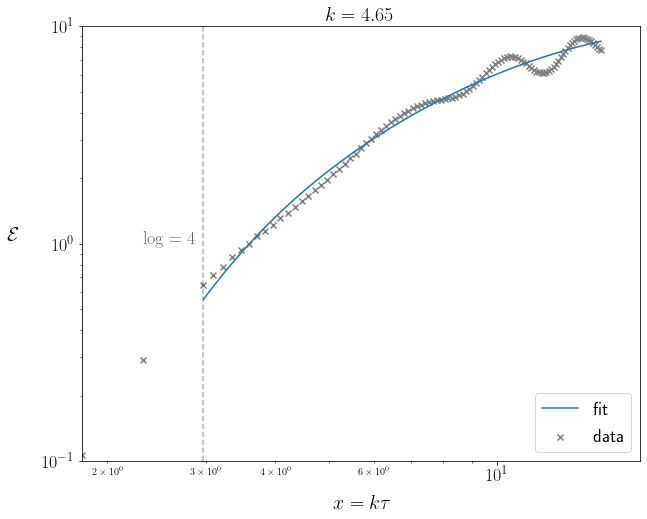

In [11]:
plt.clf()
plt.figure(figsize=(10,8))

id = 0
ik = 4

xdata = SAlist[id].k[ik]*SAlist[id].t
ydata = SAlist[id].Eevol(ik)

plt.scatter(xdata,ydata,marker='x',color='gray',label='data')

it4 = np.abs(SAlist[id].log - 4.).argmin() # time index corresponding to log = 4

xx = np.exp(np.linspace(math.log(xdata[it4]),math.log(xdata[-1]),100))
pp = fi.param[ik]
plt.plot(xx,np.exp(sp.ftrend(np.log(xx),2,*pp)),label='fit')

plt.xlim([1.8,18])
plt.ylim([1e-1,1e+1])

plt.vlines(xdata[it4],plt.ylim()[0],plt.ylim()[1],linestyle='dashed',alpha=0.3)
plt.text(xdata[it4]*0.78,math.sqrt(plt.ylim()[0]*plt.ylim()[1]),'$\log = 4$',alpha=0.6,fontsize=18)

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(loc='lower right',fontsize=18)
plt.xlabel(r'$x = k\tau$',fontsize=20,labelpad=10)
plt.ylabel(r'$\mathcal{E}$',fontsize=20,rotation=0,labelpad=30)
plt.title('$k = %.2f$'%SAlist[id].k[ik],fontsize=20)

## spectrum.saveParam, spectrum.readParam <font color='red'>[updated 2022.05.05]</font>
<font color='red'>(These functions were called savePP and readPP in the old version. Their functionality remains the same.)</font>
```python
def saveParam(fS, name='./P'):
    ...
class readParam:
    def __init__(self, name='./P'):
    ...
```
Since it takes some time to perform the fit, one can use the function `saveParam` to save the results of `fitS`.
It saves `param`, `listfit`, and `ikhistart` data as pickle files. These files are named `name_something`, where something = param, listfit, ikhistart.

In [13]:
# This produces the following files (with id = 00, 01, ..., 07) in the directory ./Pdata :
#
# id_ikhistart.pickle
# id_listfit.pickle
# id_param.pickle
#
for id in range(8):
    fi = sp.fitS(SAlist[id].Earr,SAlist[id].log,SAlist[id].t,SAlist[id].k,p=2)
    sp.saveParam(fi,'./Pdata/%02d'%id)

fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]
fit:  k = 464.33 [444/444]


One can import these files by using `readParam`:

In [12]:
# read the data of fit parameters and produce a list for 8 realizations
Plist = []
for id in range(8):
    rp = sp.readParam('./Pdata/%02d'%id)
    Plist.append(rp)

One can extract the results by using the same instance variables as `fitS`.

In [13]:
print(Plist[0].param[4])
print(Plist[0].listfit[4])

[-5.94826537  6.          0.42221421  3.          0.52639089]
True


## spectrum.calcF <font color='red'>[updated 2022.05.27]</font>

`calcF` computes the instantaneous spectrum by using the data of $\mathcal{E}$.
```python
class calcF:
    def __init__(self, data, log, t, k, k_below, **kwargs):
```

Arguments:
- `data` data array of $\mathcal{E}$ (`spectrum.readS.Earr`)
- `log` table for $\log(m_r/H)$
- `t` table for conformal time
- `k` list of comoving wavenumber  
- `k_below` mask to identify modes less than N/2

If necessary, the following options can be added: 
- `usedata` if True, it uses the data of fit parameters obtained by `fitS`. The data can be loaded by adding `fitp = data` otpion, where `data` should be `fitS` or `readParam` class object. (defalt False)
- `p` order of the polynomial function for the fit (default 2)
- `sigma` sigma for the Gaussian filter (defalt 0.5)
- `xh` criterion to switch to a simplified fit function in `fitS` (defalt -1; relevant only when `usedata=False`)
- `logstart` value of $\log(m_r/H)$ above which we perform the analytical fit (default logstart = 4)
- `verbose` it does not print progress messages when verbose=False (default True)
- `saxionmass` default is False. If True, it takes account of the non-trivial redshift for saxion spectra.
- `LL` value of lambda parameter for physical strings (relevant only when `saxionmass=True`; defalult LL = 1600.0).
- `lz2e` value of the exponent of the power law evolution of the lambda parameter for physical strings (relevant only when `saxionmass=True`; default lz2e = 0).

Outputs (class members):  
- `F` $\mathcal{F}$ defined above. This is an array with the shape F[t][k], where t is the time index and k is the index for momenta (t[t], Fnorm[t], and log[t] show the corresponding values of time, normalization factor, and log).
- `F_fit` $\mathcal{F}$ computed by using the fit part only (not including the residue).
- `x` $x=k\tau$. This is an array with the shape x[t][k], where t is the time index and k is the index for momenta.
- `Fnorm` normalization factor $\int\mathcal{F}dx$ as a function of time (1 dim. array).
- `t` table for conformal time (1 dim. array).
- `log` table for $\log(m_r/H)$ (1 dim. array).  

`calcF` deals with comtaminations from axion oscillations in the following way. First, it uses `fitS` to fit a model function to data, and subtracts the fit to obrain residue:
\begin{align}
\mathcal{R} = \mathcal{E}_{\rm data} - \mathcal{E}_{\rm fit}.
\end{align}
Then it further subtracts a linear function,
\begin{align}
\bar{\mathcal{R}} = \mathcal{R} - (\alpha x + \beta)
\end{align}
such that $\bar{\mathcal{R}}(\tau_{\rm ini}) = \bar{\mathcal{R}}(\tau_{\rm fin}) = 0$.
Here $\tau_{\rm ini}$ and $\tau_{\rm fin}$ are the initial (corresponding to `logstart`) and final time of the data, respectively. After that, it applies discrete sine transform (DST) to $\bar{\mathcal{R}}$, multiplies Gaussian filter
\begin{align}
\exp\left[-\frac{(f/k)^2}{2\sigma^2}\right],
\end{align}
and performs inverse DST to obtain data $\bar{\mathcal{R}}_{\rm filtered}$ for which oscillations are smoothed out.
In the above equation, $f$ is the frequency of DST components, $k$ the comeving wavenumber of the mode, and $\sigma$ the parameter specified by the argument `sigma`. Finally, the function calculates the derivative analytically for $\mathcal{E}_{\rm fit}$, while take a difference numerically for the residue:
\begin{align}
\mathcal{F} = \frac{d\mathcal{E}}{dx} = \frac{d\mathcal{E}_{\rm fit}}{dx} + \alpha + \frac{d\bar{\mathcal{R}}_{\rm filtered}}{dx} 
= \frac{\exp[f(\ell)]}{x}\frac{\partial f(\ell)}{\partial \ell} + \alpha + \frac{d\bar{\mathcal{R}}_{\rm filtered}}{dx}.
\end{align}

For a check, `calcF` also stores the result obtained by using the fit part only (i.e. $d\mathcal{E}/dx = d\mathcal{E}_{\rm fit}/dx$) as `F_fit`.

If `saxionmass = True`, it instead calculates
\begin{align}
\mathcal{F} = \left[\frac{d((R^{z[k]-4}\mathcal{E})_{\rm fit})}{dx} + \alpha + \frac{d\bar{\mathcal{R}}_{\rm filtered}}{dx}\right]\frac{1}{R^{z[k]-4}} = \left[\frac{\exp[f(\ell)]}{x}\frac{\partial f(\ell)}{\partial \ell} + \alpha + \frac{d\bar{\mathcal{R}}_{\rm filtered}}{dx}\right]\frac{1}{R^{z[k]-4}},
\end{align}
where
\begin{align}
\mathcal{R} = R^{z[k]-4}\mathcal{E}_{\rm data} - (R^{z[k]-4}\mathcal{E})_{\rm fit}.
\end{align}
In this case one has to provide values of `LL` and `lz2e` in the argument which are used to evaluate $z[k]$.

Since the fit procedure takes some time, it is recommended to perform `fitS` first, and load its result when we want to calculate $\mathcal{F}$. The result of `fitS` can be loaded by adding `usedata=True` option and specifying the data by using `fitp = data` otpion, where `data` should be `fitS` or `readParam` class object. Note that one has to use the same value of `p` (order of the polynomial function) as `fitS`.

In [14]:
# compute F for a single realization (id = 00)
id = 0
Ft = sp.calcF(SAlist[id].Earr,SAlist[id].log,SAlist[id].t,SAlist[id].k,SAlist[id].k_below,p=2,sigma=0.1,usedata=True,fitp=Plist[id])

<Figure size 432x288 with 0 Axes>

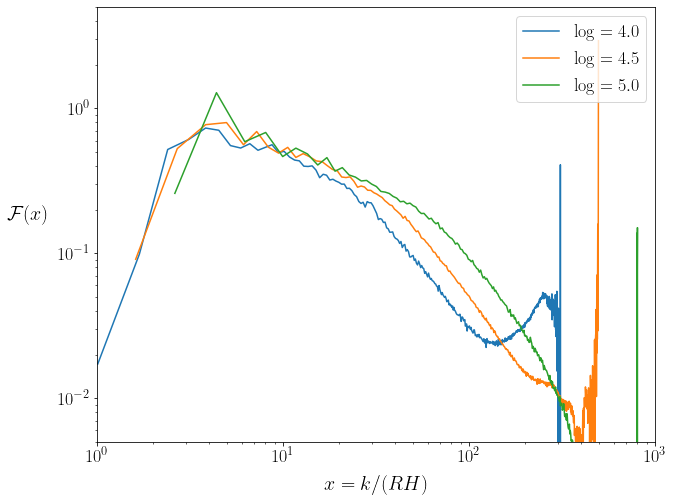

In [15]:
plt.clf()
plt.figure(figsize=(10,8))
cmap = plt.get_cmap("tab10")
logil = [4,4.5,5]
for log in logil:
    it = np.abs(Ft.log - log).argmin()
    xx = Ft.x[it]
    ff = Ft.F[it]
    plt.plot(xx,ff,label='$\log = %.1f$'%Ft.log[it])
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1000)
plt.ylim(5e-3,5)
plt.xlabel(r'$x = k/(RH)$',fontsize=20,labelpad=10)
plt.ylabel(r'$\mathcal{F}(x)$',fontsize=20,rotation=0,labelpad=30)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right',fontsize=18)

Unfortunately, for simulations with $512^3$ the mode evolution becomes quite noisy, which results in a some discrepancy between `F` and `F_fit`. In order to alleviate it, one has to perform simulations with larger box sizes. Alternatively, one could set a smaller value of `sigma` (here `sigma` = 0.1 is used), but such a choice would bias the result.

Text(0.5, 1.0, '$\\log = 4.040736$')

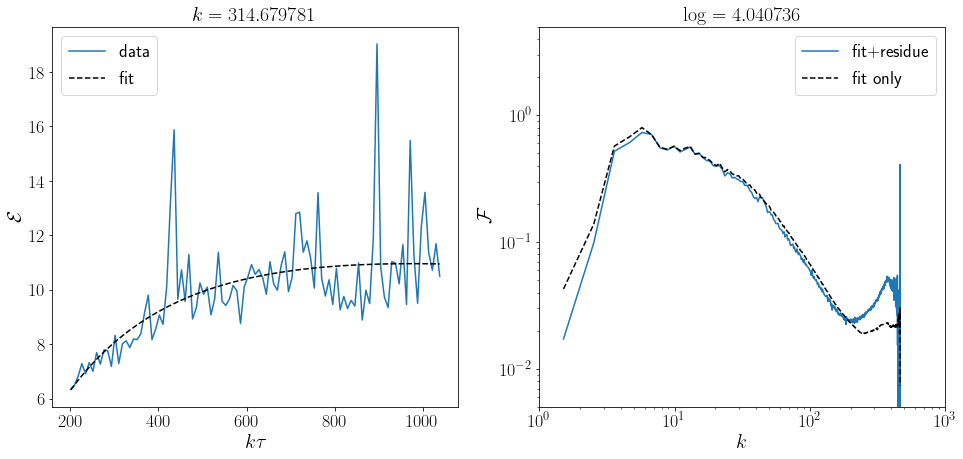

In [16]:
id = 0
ik = 300
fig, ax = plt.subplots(1,2,figsize=(16,7))

il4 = np.abs(SAlist[id].log - 4.).argmin()
w = SAlist[id].k[ik]*SAlist[id].t[il4:]
data = SAlist[id].Eevol(ik)[il4:]
par = Plist[id].param[ik]
fit = np.exp(sp.ftrend(np.log(w),2,*par))

ax[0].plot(w,data,'C0',label='data')
ax[0].plot(w,fit,"k--",label='fit')
ax[0].set_ylabel(r'$\mathcal{E}$',fontsize=20)
ax[0].set_xlabel(r'$k\tau$',fontsize=20)
ax[0].legend(fontsize=18)
ax[0].tick_params(labelsize=18)
ax[0].set_title(r'$k = %f$'%SAlist[id].k[ik],fontsize=20)

it = np.abs(Ft.log - 4.).argmin()
ax[1].plot(Ft.x[it]/Ft.t[it],Ft.F[it],label='fit+residue')
ax[1].plot(Ft.x[it]/Ft.t[it],Ft.F_fit[it],"k--",label='fit only')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(1,1000)
ax[1].set_ylim(5e-3,5)
ax[1].set_xlabel(r'$k$',fontsize=20)
ax[1].set_ylabel(r'$\mathcal{F}$',fontsize=20)
ax[1].tick_params(labelsize=18)
ax[1].legend(fontsize=18)
ax[1].set_title(r'$\log = %f$'%Ft.log[it],fontsize=20)

# Spectral index

We estimate the spectral index $q$ based on the following $\chi^2$ function:
\begin{align}
\chi^2 = \sum_l \frac{(L_l - M_l)^2}{\sigma^2},
\end{align}
where
\begin{align}
L_l = \log \mathcal{F}_l, \quad M_l = m -lq, \quad \mathrm{and} \quad l = \log x.
\end{align}
The model $M_l$ corresponds to $\mathcal{F} = e^m/x^q$ described by two parameters, $m$ and $q$. 
We define $\sigma^2$ from the residuals of the different bins at the best fit model,
\begin{align}
\sigma^2 = \frac{1}{n_{\rm bins}}\sum_l(L_l - M_l(m_{\rm min},q_{\rm min}))^2
\end{align}
where $m_{\rm min}$ and $q_{\rm min}$ are the best fit values that minimize $\sum_l(L_l-M_l)^2$.
We only use the data points within a range defined by
\begin{align}
c_{\rm min}H < k/R < c_{\rm max} m_s,
\end{align}
where the coefficients $c_{\rm min}$ and $c_{\rm max}$ can be specified in the code.

## spectrum.scanq
`scanq` estimates $q$ at every time step by using the result of `calcF`.
```python
class scanq:
    def __init__(self, inspx, inspy, insplog, cxmin=50., cxmax=1/4., **kwargs):
```

Arguments:
- `inspx` array of $x=k\tau$ (output of `calcF`)
- `inspy` array of $\mathcal{F}$ (output of `calcF`)
- `insplog` array of $\log(m_r/H)$ (output of `calcF`)
- `cxmin` value of $c_{\rm min}$ (default cxmin=50)
- `cxmax` value of $c_{\rm max}$ (default cxmax=1/4)

If necessary, the following options can be added:
- `nbin` number of bins (default 30). This option is relevant when `norebin` option is False.
- `norebin` defalut is norebin=False. If it is False, the selected data are rebinned such that a new set of bins are spaced homogeneously in $\log x$ and the total number of bins becomes nbin. If it is True, it does not rebin the data and simply uses the raw data of $\mathcal{F}$.
- `typesigma` option to estimate sigma^2 in the denominator of chi^2 (default typesigma=1)  
 0 : sigma = residuals of different bins  
 1 : sigma = residuals/sqrt(n_bin)  
 2 : conservative estimate of "sigma" to define confidence interval based on the maximum value of residuals of different bins 
- `verbose` it does not print progress messages when verbose=False (default True)

Outputs (class members; below we describe only relevant ones; see spectrum.py for more descriptions about other outputs):  
- `qbest` best fit values of q as a function of time (1 dim. array)
- `mbest` best fit values of m as a function of time (1 dim. array)
- `sigmaq` 1 sigma confidence interval of q as a function of time (1 dim. array)
- `sigmam` 1 sigma confidence interval of m as a function of time (1 dim. array)
- `log` array for $\log(m_r/H)$ (1 dim. array)

In [17]:
# Here we compare the reuslts obtained from cmin = 30 and those from cmin = 50.
# This uses the object `Ft` produced in spectrum.calcF section.
qt = []
for cm in [30,50]:
    q = sp.scanq(Ft.x,Ft.F,Ft.log,cm)
    qt.append(q)

100/100, log = 5.64
100/100, log = 5.64


<Figure size 432x288 with 0 Axes>

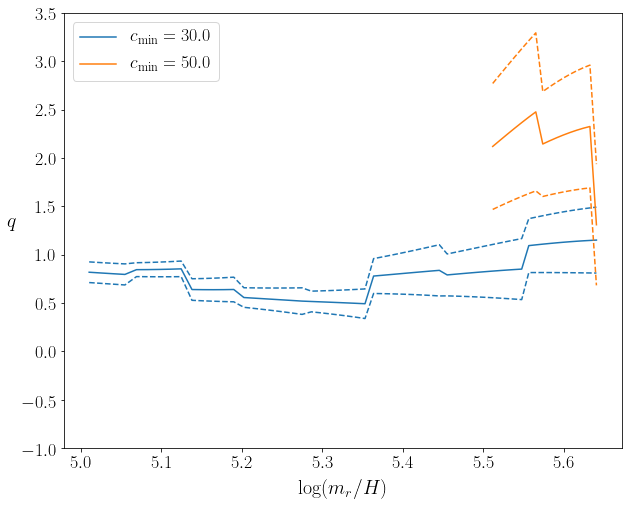

In [18]:
plt.clf()
plt.figure(figsize=(10,8))
cmap = plt.get_cmap("tab10")

cml = [30,50]

for iq in range(2):
    plt.plot(qt[iq].log,qt[iq].qbest,color=cmap(iq),label=r'$c_{\rm min} = %.1f$'%cml[iq])
    plt.plot(qt[iq].log,qt[iq].qbest+qt[iq].sigmaq,color=cmap(iq),linestyle='dashed')
    plt.plot(qt[iq].log,qt[iq].qbest-qt[iq].sigmaq,color=cmap(iq),linestyle='dashed')

plt.ylim([-1,3.5])

plt.tick_params(labelsize=18)
plt.xlabel(r'$\log(m_r/H)$',fontsize=20,labelpad=10)
plt.ylabel(r'$q$',fontsize=20,rotation=0,labelpad=10)
plt.legend(loc='upper left',fontsize=18)

For $c_{\rm min} = 50$, $q$ can be estimated only at times later than $\log \gtrsim 5.5$, since before that time there are not enough data points in the specified range $[c_{\rm min}H,c_{\rm max}m_r]$ (i.e. the hierarchy between $H$ and $m_r$ is not so large at early times). Furthermore, the estimated values of $q$ have large errors because of the lack of data points. It is possible to estimate $q$ at early times by reducing the value of $c_{\rm min}$ (or increasing the value of $c_{\rm max}$), but it may also lead to a wrong result because the data might be affected by some feature at around the infrared peak.

One can check the results by comparing the data of $\mathcal{F}$ and the best fit slope:

Text(0.5, 1.0, '$\\log(m_r/H) = 5.010228$')

<Figure size 432x288 with 0 Axes>

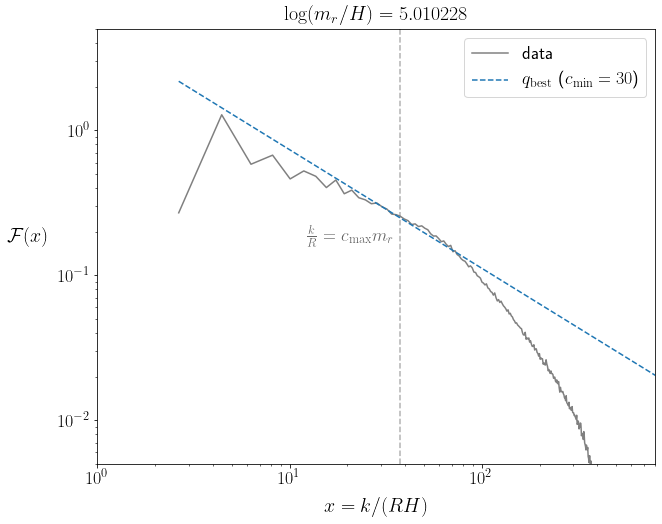

In [19]:
ind = 41

plt.clf()
plt.figure(figsize=(10,8))

xx = Ft.x[ind]
ff = Ft.F[ind]
plt.plot(xx,ff,label='data',color='gray')

xxx = np.linspace(math.log(xx[0]),math.log(xx[-1]),100)
plt.plot(np.exp(xxx),math.exp(qt[0].mbest[ind])/np.exp(xxx)**qt[0].qbest[ind],linestyle='dashed',label=r'$q_{\rm best}$ ($c_{\rm min} = 30$)')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,800)
plt.ylim(5e-3,5)

plt.vlines(math.exp(Ft.log[ind])/4,plt.ylim()[0],plt.ylim()[1],linestyle='dashed',alpha=0.3)
plt.text(0.33*math.exp(Ft.log[ind])/4,math.sqrt(plt.ylim()[0]*plt.ylim()[1]),r'$\frac{k}{R}=c_{\rm max}m_r$',alpha=0.6,fontsize=18)

plt.xlabel(r'$x = k/(RH)$',fontsize=20,labelpad=10)
plt.ylabel(r'$\mathcal{F}(x)$',fontsize=20,rotation=0,labelpad=30)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right',fontsize=18)
plt.title('$\log(m_r/H) = %f$'%Ft.log[ind],fontsize=20)

Text(0.5, 1.0, '$\\log(m_r/H) = 5.590912$')

<Figure size 432x288 with 0 Axes>

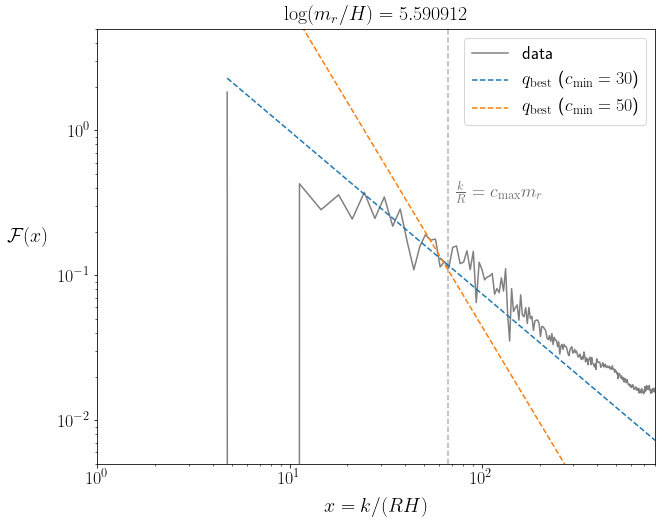

In [20]:
ind = 93

plt.clf()
plt.figure(figsize=(10,8))

xx = Ft.x[ind]
ff = Ft.F[ind]
plt.plot(xx,ff,label='data',color='gray')

xxx = np.linspace(math.log(xx[0]),math.log(xx[-1]),100)
plt.plot(np.exp(xxx),math.exp(qt[0].mbest[ind])/np.exp(xxx)**qt[0].qbest[ind],linestyle='dashed',label=r'$q_{\rm best}$ ($c_{\rm min} = 30$)')
plt.plot(np.exp(xxx),math.exp(qt[1].mbest[ind])/np.exp(xxx)**qt[1].qbest[ind],linestyle='dashed',label=r'$q_{\rm best}$ ($c_{\rm min} = 50$)')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,800)
plt.ylim(5e-3,5)

plt.vlines(math.exp(Ft.log[ind])/4,plt.ylim()[0],plt.ylim()[1],linestyle='dashed',alpha=0.3)
plt.text(1.1*math.exp(Ft.log[ind])/4,2*math.sqrt(plt.ylim()[0]*plt.ylim()[1]),r'$\frac{k}{R}=c_{\rm max}m_r$',alpha=0.6,fontsize=18)

plt.xlabel(r'$x = k/(RH)$',fontsize=20,labelpad=10)
plt.ylabel(r'$\mathcal{F}(x)$',fontsize=20,rotation=0,labelpad=30)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right',fontsize=18)
plt.title('$\log(m_r/H) = %f$'%Ft.log[ind],fontsize=20)

## spectrum.aveq
We can take an average of $q$ over many realizations.
```python
def aveq(qlist):
    ...
    return [q,sigmaq,sigmaq/math.sqrt(Nreal),log]
```
Arguments:
- `qlist` list of scanq class object

It returns a list (size 4) whose components are  
0. average value of q as a function of time (1 dim. array)  
1. standard deviation (sigma) of q (1 dim. array)
2. sigma/sqrt(Nreal) where Nreal is the number of realizations (1 dim. array)
3. array for $\log(m_r/H)$ (1 dim. array)

In [21]:
# compute F for 8 realizations
Flist = []
for p in SAlist:
    id = SAlist.index(p)
    F = sp.calcF(p.Earr,p.log,p.t,p.k,p.k_below,verbose=False,p=2,sigma=0.1,usedata=True,fitp=Plist[id])
    Flist.append(F)
    print('\rsimu %02d done'%id,end="")

simu 07 done

In [22]:
# estimate q for 8 realizations
qlist = []
for f in Flist:
    q = sp.scanq(f.x,f.F,f.log,30,verbose=False)
    qlist.append(q)
    print('\rsimu %02d done'%Flist.index(f),end="")

simu 07 done

In [23]:
# take an ensemble average
qa = sp.aveq(qlist)

<Figure size 432x288 with 0 Axes>

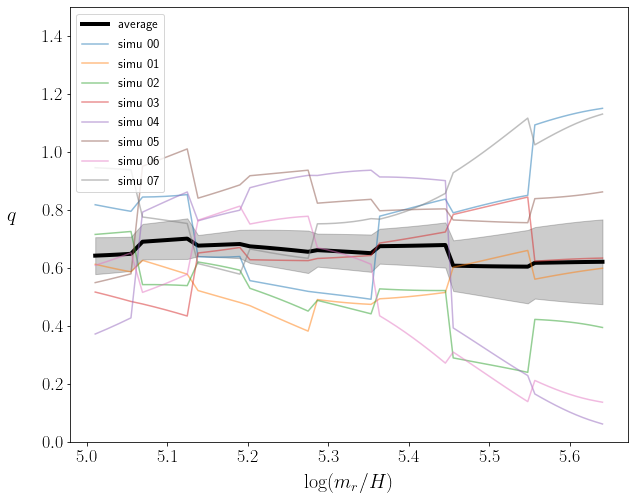

In [24]:
plt.clf()
plt.figure(figsize=(10,8))

plt.fill_between(qa[3],qa[0]-qa[2],qa[0]+qa[2],color='black',alpha=0.2)
plt.plot(qa[3],qa[0],color='black',linewidth=4,label='average')

for q in qlist:
    plt.plot(q.log,q.qbest,alpha=0.5,label=r'simu %02d'%qlist.index(q))
    
plt.ylim([0,1.5])

plt.tick_params(labelsize=18)
plt.xlabel(r'$\log(m_r/H)$',fontsize=20,labelpad=10)
plt.ylabel(r'$q$',fontsize=20,rotation=0,labelpad=30)
plt.legend(loc='upper left',fontsize=13)

Since these results are obtained from simulations with the box size 512^3 where the dynamical range is quite limited, the logarithmic growth of $q$ is not obvious. One has to perform simulations with larger box sizes (or larger hierarchy between two scales) in order to see such a trend.

# Energy radiation rate

From data of axion/saxion energy densitis, the net energy density emission rate can be calculated as
\begin{align}
\Gamma_a &= R^{-4}\frac{d}{dt}(R^4\rho_a) \quad (\text{for axions}),\\
\Gamma_r &= R^{-\langle z\rangle}\frac{d}{dt}(R^{\langle z\rangle}\rho_r) \quad (\text{for saxions}),
\end{align}
where $\langle z\rangle$ is the mean redshift exponent,
\begin{align}
\langle z \rangle = \frac{1}{\rho_r}\int dk z[k] \frac{\partial\rho_r}{\partial k}.
\end{align}
In terms of the dimensionless quantities, they can be written as
\begin{align}
\frac{\Gamma_a}{f_a^2H^3} &= \tau\frac{d}{d\tau}(\tau^4\bar{\rho}_a),\\
\frac{\Gamma_r}{f_a^2H^3} &= \tau^{5-\langle z\rangle}\frac{d}{d\tau}(\tau^{\langle z\rangle}\bar{\rho}_r),
\end{align}
where $\bar{\rho} = \rho/(f_aH_1)^2$.

## spectrum.calcGamma <font color='red'>[added 2021.11.04]</font>

This function calculates the energy radiation rate.
```python
def calcGamma(energy, t, log, **kwargs):
    ...
    return gamma, gamma_diff, tm
```

Arguments:
- `energy` array of eneragy
- `t` array of comformal time
- `log` array of $\log(m_r/H)$

If necessary, the following options can be added:
- `p` order of the polynomial function for the fit (default 2)
- `sigma` sigma for the Gaussian filter (defalt 0.25)
- `logstart` value of $\log(m_r/H)$ above which we calculate the energy radiation rate (default logstart = 4)
- `z` array of the mean redshift exponent $\langle z\rangle$

It returns 3 arrays `gamma, gamma_diff, tm`, where `gamma` and `gamma_diff` are dimensionless quantities $\Gamma/(f_a^2 H^3)$ and `tm` is an array of conformal time. The time derivative is computated in 2 different ways: using analytical fit (which gives `gamma`) and just a finite difference via `np.gradient` (which gives `gamma_diff`).

The analytical fit is performed in the same way as `fitS` and `calcF`. First we fit the following function to the data of $\log(\tau^4\bar{\rho})$ (or $\log(\tau^{\langle z\rangle}\bar{\rho})$),

\begin{align}
f_a(\ell) = a_0 + a_1\ell + \cdots + a_p\ell^p
\end{align}

with $\ell = \log\tau$. Then we calculate the residue $\mathcal{R} = (\tau^{\langle z\rangle}\bar{\rho})_{\rm data} - (\tau^{\langle z\rangle}\bar{\rho})_{\rm fit}$, subtract the linear function $\bar{\mathcal{R}} = \mathcal{R} - (\alpha x + \beta)$ with $\bar{\mathcal{R}}(\tau_{\rm ini}) = \bar{\mathcal{R}}(\tau_{\rm fin}) = 0$, where $\tau_{\rm ini}$ and $\tau_{\rm fin}$ are the initial (corresponding to `logstart`) and final time of the data, respectively, and apply DST with Gaussian filter to $\bar{\mathcal{R}}$. With this procedure, the energy emission rate is given by

\begin{align}
\frac{\Gamma}{f_a^2H^3} = \tau^{5-\langle z\rangle}\left[\frac{\exp(f_a(\ell))}{\tau}\frac{df_a(\ell)}{d\ell} + \alpha + \frac{d\bar{\mathcal{R}}_{\mathrm{filtered}}}{d\tau}\right].
\end{align}

If the time evolution of $\langle z\rangle$ is obtained as 1 dim. array `z`, one can use it (argument) to compute the saxion energy radiation rate for the case of the non-trivial redshift exponent. Otherwise it assumes $\langle z \rangle =4$.

<Figure size 432x288 with 0 Axes>

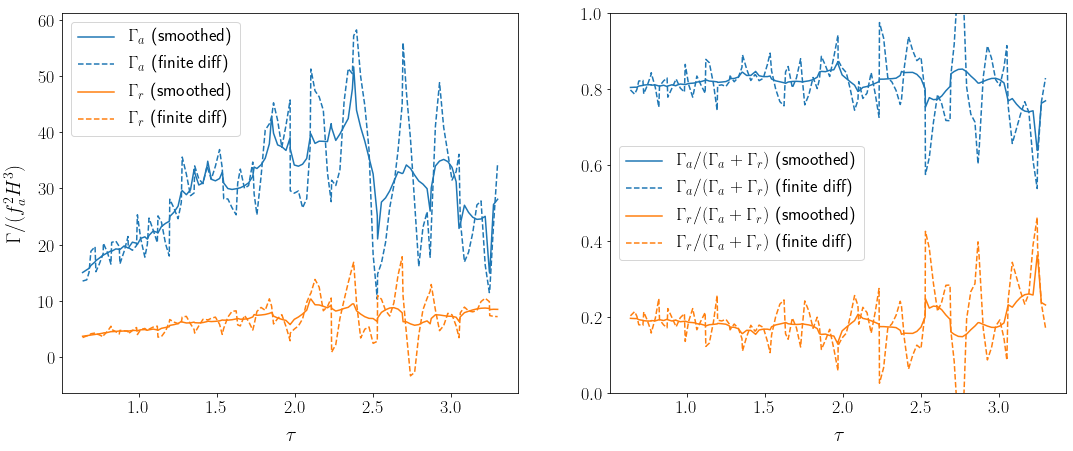

In [26]:
id = 0
tt = pa.gml(mflist[id],'ct')
ll = pa.gml(mflist[id],'logi')
ea = 2.*pa.gml(mflist[id],'eAK')
es = 2.*pa.gml(mflist[id],'eSK')

# Since this is the PRS case, we do not need to calculate z for saxions and simply use z = 4.
ga, gad, ta = sp.calcGamma(ea,tt,ll,sigma=0.1)
gs, gsd, ts = sp.calcGamma(es,tt,ll,sigma=0.1)

plt.clf()
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,2,figsize=(18,7))

ax[0].plot(ta,ga,color=cmap(0),label=r'$\Gamma_a$ (smoothed)')
ax[0].plot(ta,gad,color=cmap(0),linestyle='dashed',label=r'$\Gamma_a$ (finite diff)')
ax[0].plot(ta,gs,color=cmap(1),label=r'$\Gamma_r$ (smoothed)')
ax[0].plot(ta,gsd,color=cmap(1),linestyle='dashed',label=r'$\Gamma_r$ (finite diff)')
ax[0].set_ylabel(r'$\Gamma/(f_a^2H^3)$',fontsize=20,labelpad=10)

ax[1].plot(ta,ga/(ga+gs),color=cmap(0),label=r'$\Gamma_a/(\Gamma_a+\Gamma_r)$ (smoothed)')
ax[1].plot(ta,gad/(gad+gsd),color=cmap(0),linestyle='dashed',label=r'$\Gamma_a/(\Gamma_a+\Gamma_r)$ (finite diff)')
ax[1].plot(ta,gs/(ga+gs),color=cmap(1),label=r'$\Gamma_r/(\Gamma_a+\Gamma_r)$ (smoothed)')
ax[1].plot(ta,gsd/(gad+gsd),color=cmap(1),linestyle='dashed',label=r'$\Gamma_r/(\Gamma_a+\Gamma_r)$ (finite diff)')
ax[1].set_ylim(0,1)

for i in range(2):
    ax[i].tick_params(labelsize=18)
    ax[i].set_xlabel(r'$\tau$',fontsize=20,labelpad=10)
    ax[i].legend(fontsize=18)